# Fitbit Exploration
For an explanation on the variables, take a look at the [data dictionary created by Fitabase](https://www.fitabase.com/media/1546/fitabasedatadictionary.pdf).

## Sleep Schedule Check
In this notebook we take a look at how participants' sleep schedules might have shifted due to the pandemic. We have to include participants from the first cohort only since these are the ones that would have had data from before the seriousness of the pandemic started to affect students i.e. Spring Break.

In [1]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Sleep Data
We have sleep data recorded in slightly different ways from the two cohorts.

## BPEACE1
The BPEACE1 data is downloaded directly from [Fitabase](https://app.fitabase.com/DownloadData/Project/0f0d46af-cd33-4254-a73a-4611f951c3c5) and all the information is contained in the ```sleepLogInfo``` data file.

In [2]:
c1 = pd.read_csv("../data/raw/bpeace1/fitbit/sleepLogInfo_merged.csv",
                parse_dates=['StartTime'],infer_datetime_format=True)
c1.head()

,Id,LogId,StartTime,Duration,Efficiency,IsMainSleep,MinutesAfterWakeup,MinutesAsleep,MinutesToFallAsleep,TimeInBed,AwakeCount,AwakeDuration,RestlessCount,RestlessDuration
0,101,25904802628,2020-02-07 22:17:30,31980000,89,True,0,477,0,533,5,12,23,44
1,101,25904802629,2020-02-09 00:14:00,22800000,94,True,0,357,0,380,3,5,13,18
2,101,25904802630,2020-02-09 23:35:00,32340000,89,True,0,479,0,539,4,14,23,46
3,101,25904802631,2020-02-11 01:05:00,23940000,92,True,0,368,0,399,2,4,13,27
4,101,25904802632,2020-02-12 00:15:30,22860000,93,True,0,354,0,381,2,5,15,22


In [3]:
n = len(c1['Id'].unique())
print(f'Number of participants: {n}')

Number of participants: 77


## BPEACE2
We have already processed the BPEACE2 data into something easy to import.

In [4]:
c2 = pd.read_csv("../data/processed/bpeace2-fitbit-sleep-daily.csv",
                 index_col=0,parse_dates=['date','endTime','startTime'],infer_datetime_format=True)
c2.head()

,dateOfSleep,duration,efficiency,endTime,infoCode,isMainSleep,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,minutesToFallAsleep,startTime,timeInBed,beiwe
date,,,,,,,,,,,,,,
2020-05-14,2020-05-14,24360000,97,2020-05-14 07:13:00,0,True,27170628887,0,379,27,0,2020-05-14 00:27:00,406,hfttkth7
2020-05-15,2020-05-15,29580000,87,2020-05-15 08:06:30,0,True,27187368950,8,392,101,0,2020-05-14 23:53:30,493,hfttkth7
2020-05-16,2020-05-16,19740000,95,2020-05-16 04:57:00,0,True,27197675883,7,287,42,0,2020-05-15 23:28:00,329,hfttkth7
2020-05-17,2020-05-17,26820000,96,2020-05-17 09:28:30,0,True,27214680283,8,403,44,0,2020-05-17 02:01:30,447,hfttkth7
2020-05-18,2020-05-18,24960000,92,2020-05-18 07:20:00,0,True,27227113904,0,351,65,0,2020-05-18 00:24:00,416,hfttkth7


## ID Crossover
Now we need a way to link the participants across the the two studies.

### BPEACE1
The ID list includes participant name

In [5]:
c1_id = pd.read_csv("../data/raw/bpeace1/admin/id_list.csv")
c1_id['Name'] = c1_id['First'].str.cat(c1_id['Last'],sep=" ")
for i in range(len(c1_id)):
    c1_id.loc[i,'Fitbit No'] = int(str(c1_id.loc[i,'Fitbit No'])[9:11])
c1_id.head()

,Record ID,Beiwe ID,BB No,Actual BB No,Fitbit No,UT EID,First,Last,Email,Name
0,162,cjbncgvw,2.020011e+13,29.0,45,aso544,Sofia,Ocegueda,NaN,Sofia Ocegueda
1,18,g46wfzjn,2.020011e+13,28.0,28,aja3295,Aaron,Alterman,NaN,Aaron Alterman
2,90,4mydzypv,2.020011e+13,27.0,59,zmm434,Zoe,McDowell,NaN,Zoe McDowell
3,196,mi3pnw3b,2.020011e+13,26.0,44,etn335,elizabeth,nguyen,NaN,elizabeth nguyen
4,49,b9jm44nv,2.020011e+13,25.0,46,cbj582,Colleen,Jones,NaN,Colleen Jones


### BPEACE2
This ID list doesn't originally contain the participants, but we can add those.

In [6]:
c2_id = pd.read_excel("../data/raw/bpeace2/admin/id_crossover.xlsx")
c2_id['Name'] = c2_id['First'].str.cat(c2_id['Last'],sep=" ")
c2_id.head()

,ID,Beiwe ID,First,Last,Beacon,Fitbit Number,Name
0,1.0,y1tvkx14,Aaron,Alterman,NaN,18,Aaron Alterman
1,2.0,pgvvwyvh,Aaron,Wheat,NaN,21,Aaron Wheat
2,4.0,idbkjh8u,Alana,Martinez,30.0,22,Alana Martinez
3,5.0,eyf8oqwl,Alexander,Chan,NaN,23,Alexander Chan
4,6.0,789gcb6u,Adriana,Banchs,NaN,17,Adriana Banchs


### BPEACE
Overall ID list looks at the last name crossover since there is no overlap.

In [7]:
id_list = pd.merge(left=c1_id,right=c2_id,left_on="Name",right_on="Name")
id_list.drop(['BB No','UT EID','Email'],inplace=True,axis=1)
id_list.columns = ['redcap1','beiwe1','beacon1','fitbit1','first1','last1','name','redcap2','beiwe2','first2','last2','beacon2','fitbit2']
id_list.head()         

,redcap1,beiwe1,beacon1,fitbit1,first1,last1,name,redcap2,beiwe2,first2,last2,beacon2,fitbit2
0,18,g46wfzjn,28.0,28,Aaron,Alterman,Aaron Alterman,1.0,y1tvkx14,Aaron,Alterman,NaN,18
1,90,4mydzypv,27.0,59,Zoe,McDowell,Zoe McDowell,77.0,i31pt4b4,Zoe,McDowell,11.0,57
2,154,eb1vt4a2,24.0,48,Gerald,Maeda,Gerald Maeda,34.0,vr9j5rry,Gerald,Maeda,25.0,36
3,110,jj1do3qt,23.0,47,Alana,Martinez,Alana Martinez,4.0,idbkjh8u,Alana,Martinez,30.0,22
4,152,b2v1pnc3,22.0,50,Joseph,Clements,Joseph Clements,40.0,5bg4j1pp,Joseph,Clements,NaN,NaN


# Visualizations
Now we look at some visualizations

## Histogram

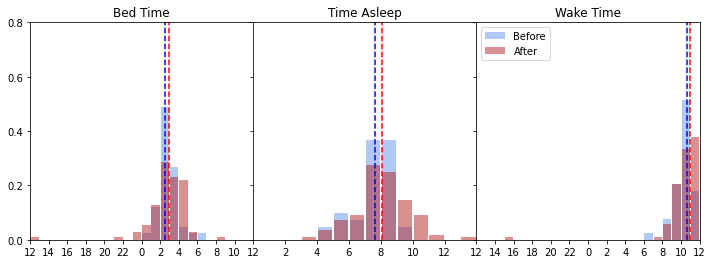

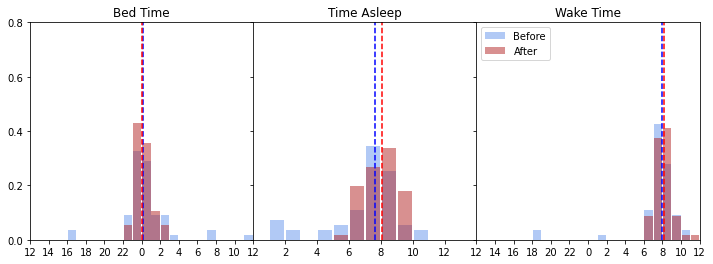

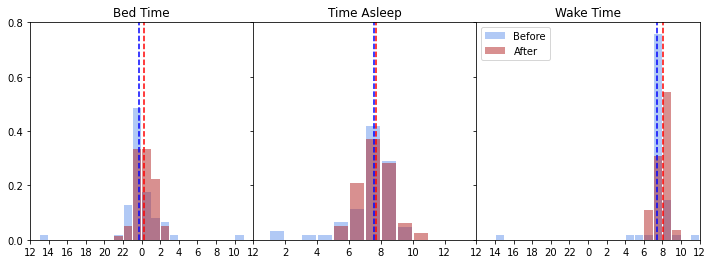

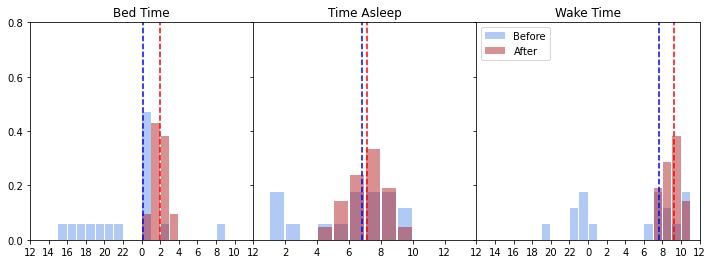

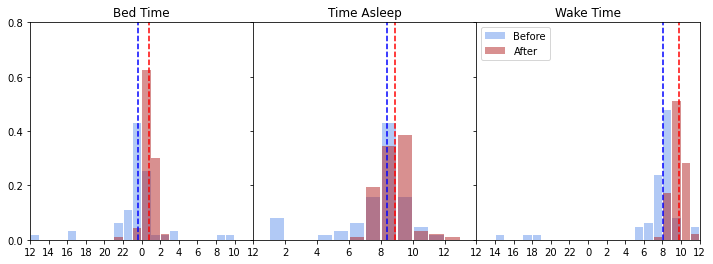

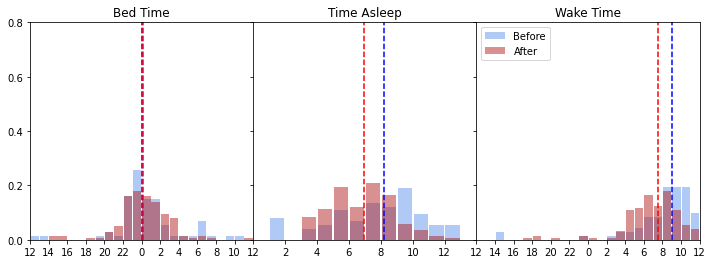

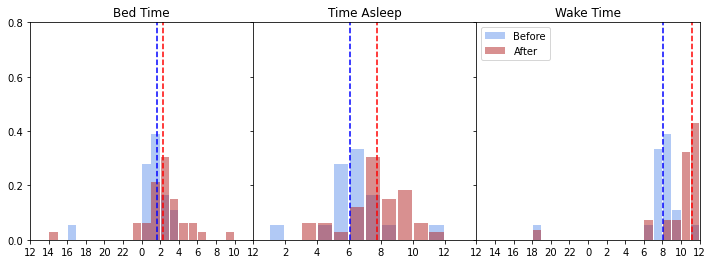

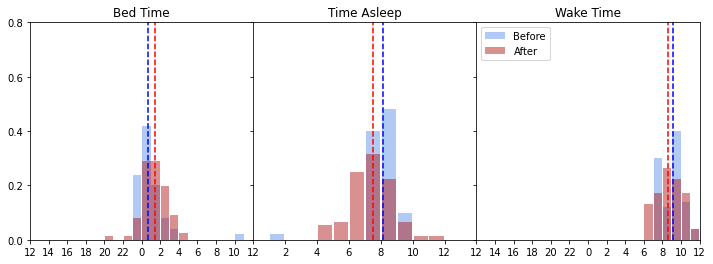

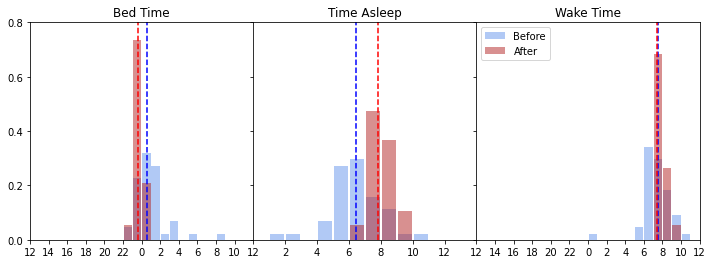

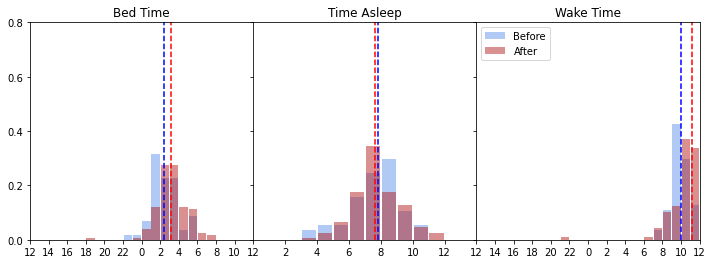

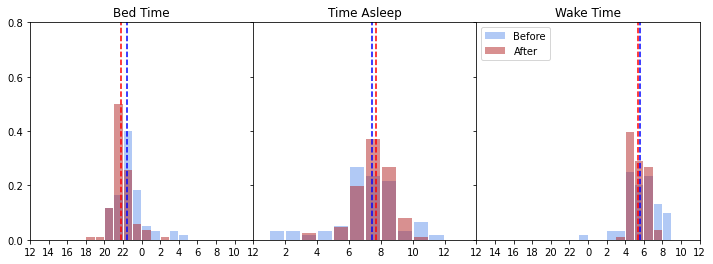

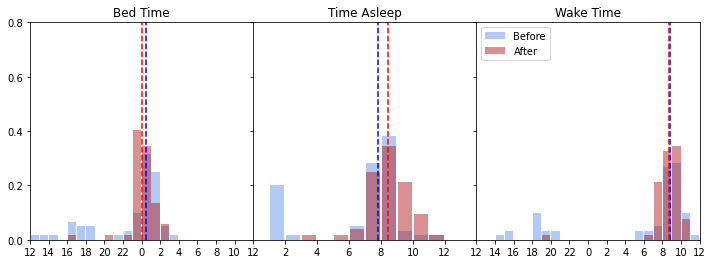

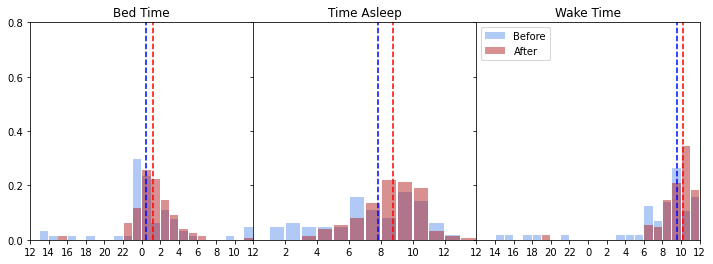

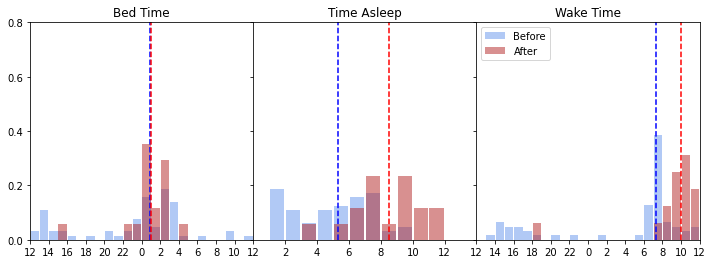

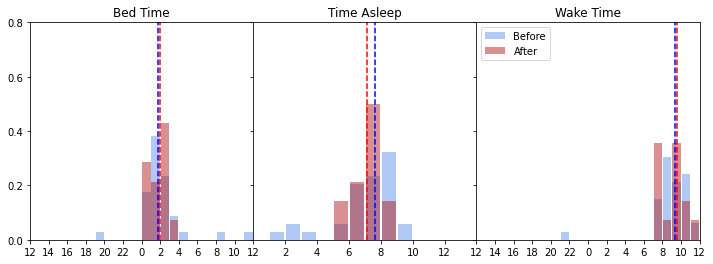

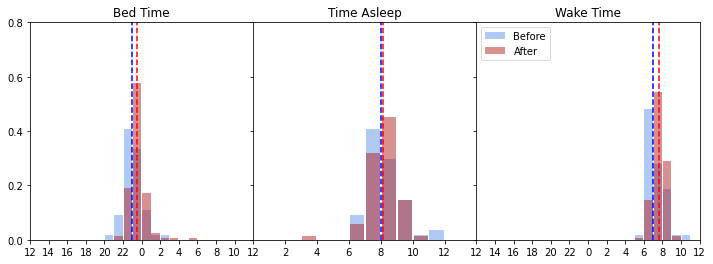

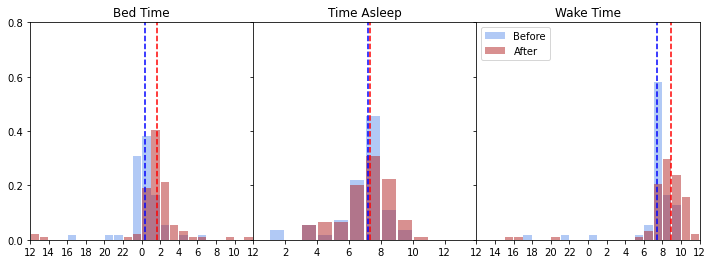

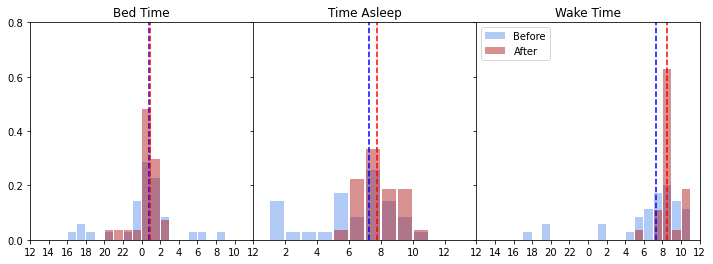

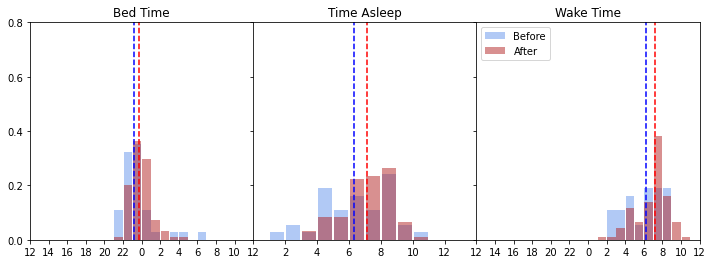

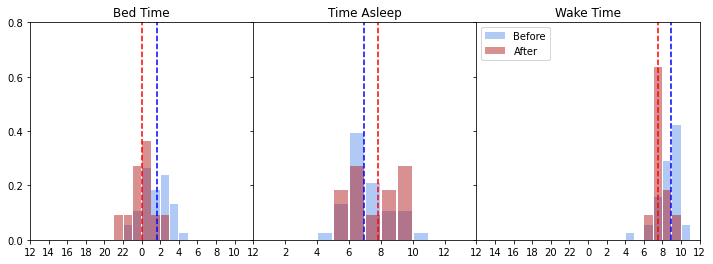

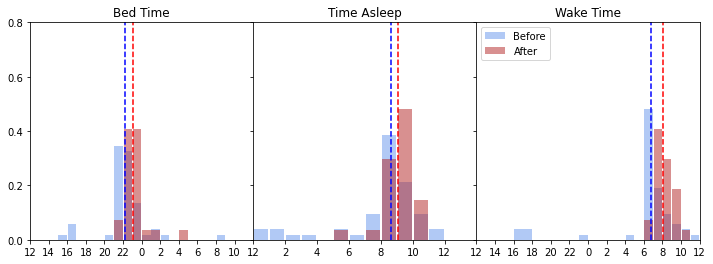

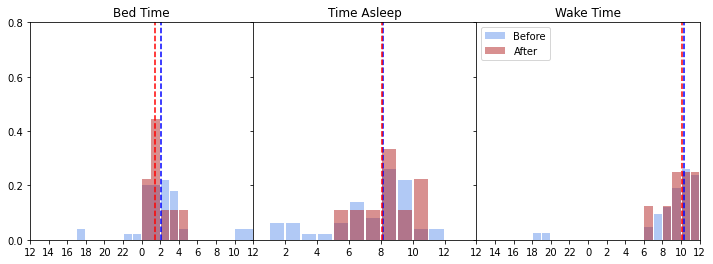

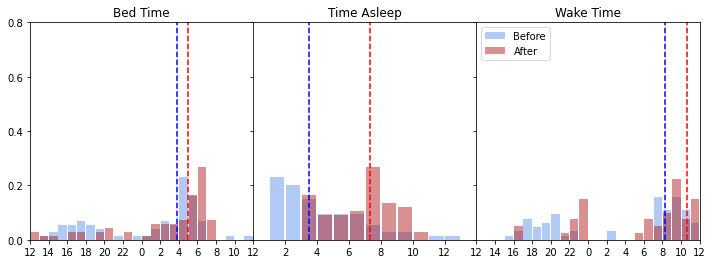

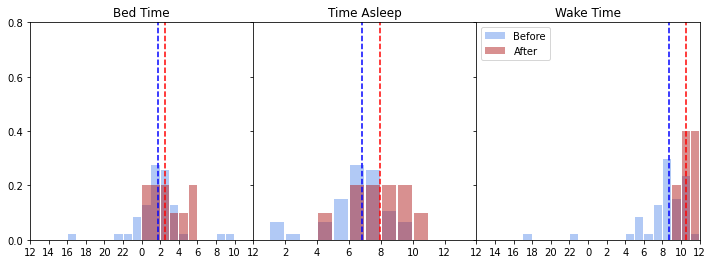

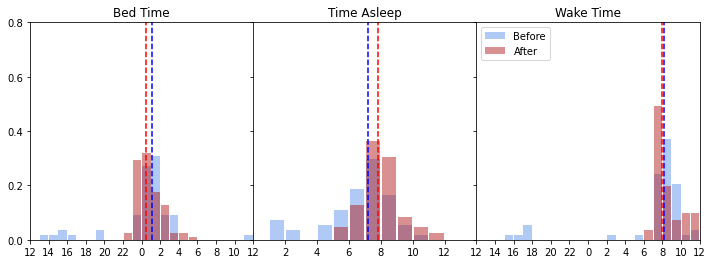

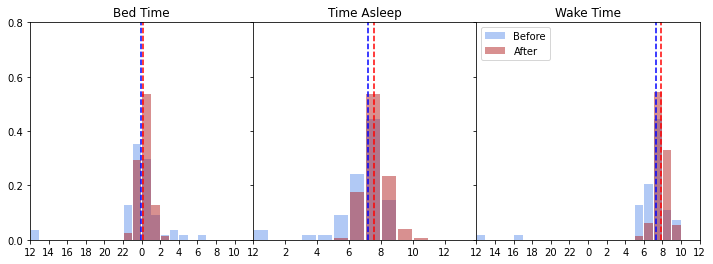

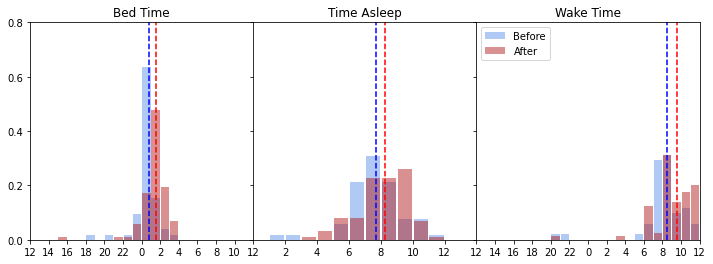

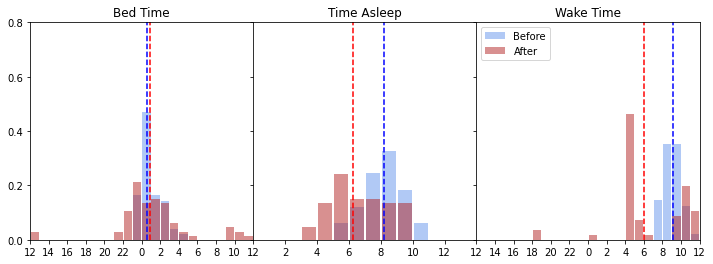

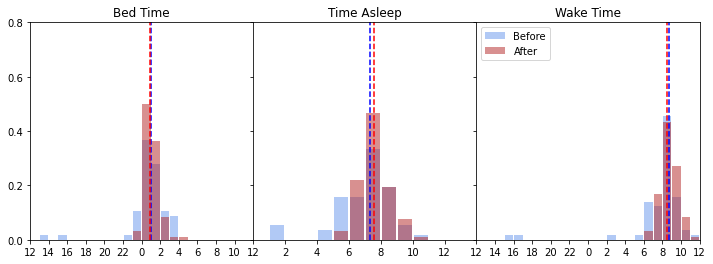

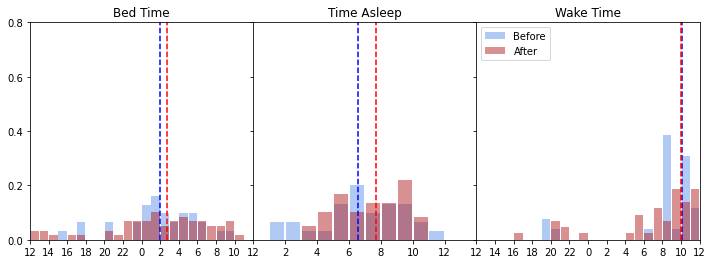

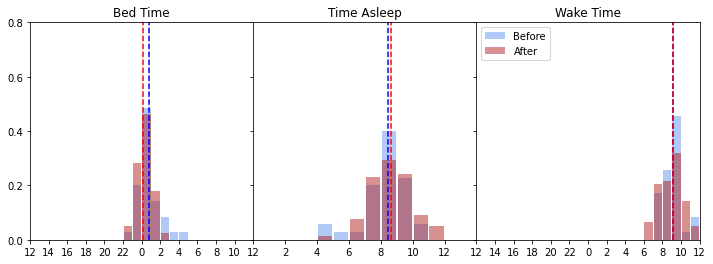

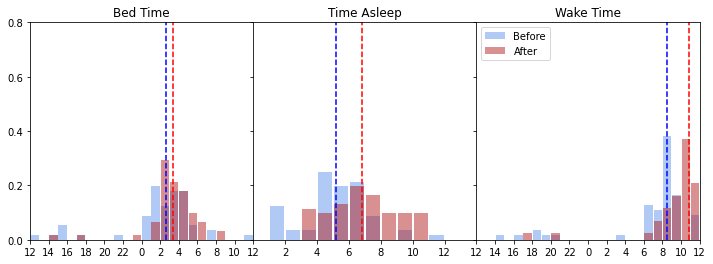

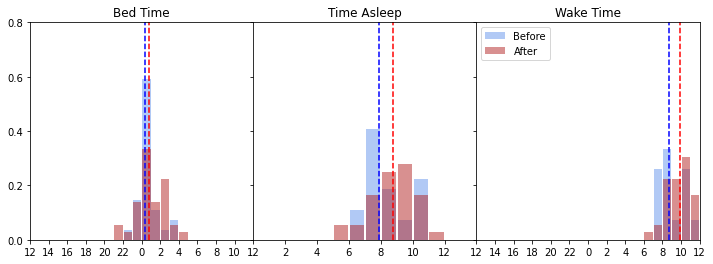

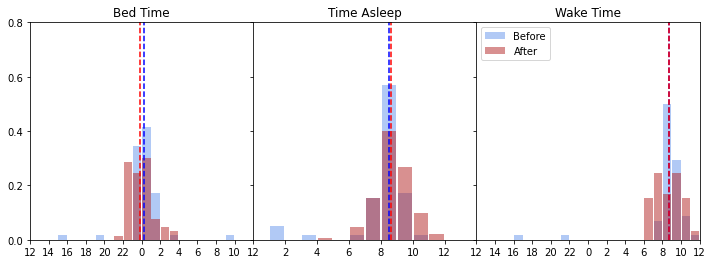

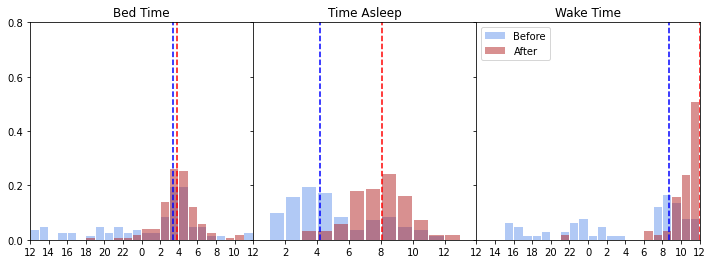

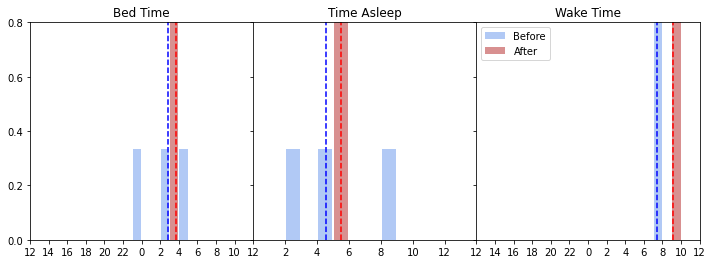

In [16]:
for i in range(len(id_list)):
    # cohort 1
    c1_id = id_list['redcap1'][i]
    c1_pt = c1[c1['Id'] == c1_id]
    c1_pt_start_hour = c1_pt['StartTime'].dt.hour.values + c1_pt['StartTime'].dt.minute.values / 60
    c1_td = []
    for hour in c1_pt_start_hour:
        if hour < 12:
            c1_td.append(hour)
        else:
            c1_td.append(hour-24)
            
    # cohort 2
    c2_id = id_list['beiwe2'][i]
    c2_pt = c2[c2['beiwe'] == c2_id]
    c2_pt_start_hour = c2_pt['startTime'].dt.hour.values + c2_pt['startTime'].dt.minute.values / 60
    c2_td = []
    for hour in c2_pt_start_hour:
        if hour < 12:
            c2_td.append(hour)
        else:
            c2_td.append(hour-24)
            
    if len(c1_td) > 0 and len(c2_td) > 0:
        fig, axes = plt.subplots(1,3,figsize=(12,4),sharey='row')
        # Start Time
        ax = axes[0]
        ax.hist(c1_td,bins=np.arange(-12,13,1),rwidth=0.9,density=True,color='cornflowerblue',alpha = 0.5,label="Before")
        ax.hist(c2_td,bins=np.arange(-12,13,1),rwidth=0.9,density=True,color='firebrick', alpha=0.5,label="After")
        
        ax.axvline(np.median(c1_td),color='blue',linestyle='dashed')
        ax.axvline(np.median(c2_td),color='red',linestyle='dashed')

        ax.set_xlim([-12,12])
        ax.set_xticks(np.arange(-12,13,2))
        ax.set_xticklabels(['12','14','16','18','20','22','0','2','4','6','8','10','12'])

        ax.set_ylim(0,0.8)
        ax.set_yticks(np.arange(0,1,0.2))
        ax.set_title('Bed Time')
        
        # Duration
        ax = axes[1]
        ax.hist(c1_pt["Duration"]/1000/60/60,bins=np.arange(0,15,1),rwidth=0.9,density=True,color='cornflowerblue',alpha = 0.5,label="Before")
        ax.hist(c2_pt["duration"]/1000/60/60,bins=np.arange(0,15,1),rwidth=0.9,density=True,color='firebrick', alpha=0.5,label="After")
        
        ax.axvline(np.median(c1_pt["Duration"]/1000/60/60),color='blue',linestyle='dashed')
        ax.axvline(np.median(c2_pt["duration"]/1000/60/60),color='red',linestyle='dashed')
        
        ax.set_xlim([0,14])
        ax.set_xticks(np.arange(2,14,2))
        
        ax.set_ylim(0,0.8)
        ax.set_yticks(np.arange(0,1,0.2))
        ax.set_title('Time Asleep')
        
        # End Time
        ax = axes[2]
        c1_end = c1_td + c1_pt["Duration"]/1000/60/60
        c2_end = c2_td + c2_pt["duration"]/1000/60/60
        ax.hist(c1_end,bins=np.arange(-12,13,1),rwidth=0.9,density=True,color='cornflowerblue',alpha = 0.5,label="Before")
        ax.hist(c2_end,bins=np.arange(-12,13,1),rwidth=0.9,density=True,color='firebrick',alpha = 0.5,label="After")
        
        ax.axvline(np.median(c1_end),color='blue',linestyle='dashed')
        ax.axvline(np.median(c2_end),color='red',linestyle='dashed')
        
        ax.set_xlim([-12,12])
        ax.set_xticks(np.arange(-12,13,2))
        ax.set_xticklabels(['12','14','16','18','20','22','0','2','4','6','8','10','12'])
        
        ax.set_ylim(0,0.8)
        ax.set_yticks(np.arange(0,1,0.2))
        ax.set_title('Wake Time')
        
        ax.legend()
        
        plt.subplots_adjust(wspace=0)
        plt.show()
        plt.close()

## Violin Plots

In [17]:
def removeOutliers(li,how='iqr'):
    '''
    Remove outliers
    
    Inputs:
    - li: the list of values
    - how: how the outliers are removed; only iqr and z are acceptable inputs
    '''
    if how == 'iqr':
        Q1 = np.quantile(li,.25)
        Q3 = np.quantile(li,.75)
        IQR = Q3 - Q1
        li = np.array(li)
        new_list = li[~((li < (Q1 - 1.5 * IQR)) |(li > (Q3 + 1.5 * IQR)))]
        
        return new_list
    elif how == 'z':
        pass
    else:
        return li

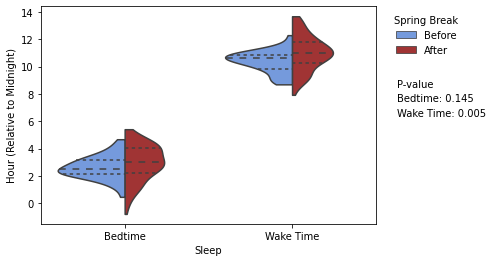

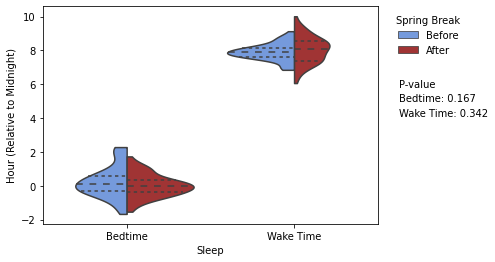

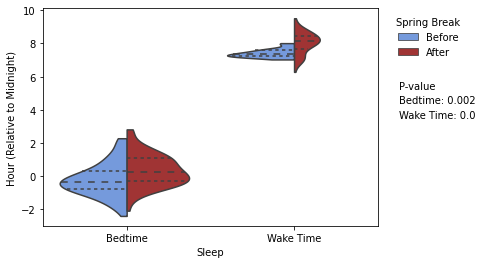

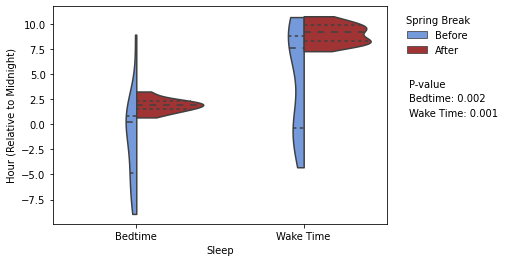

C1: 152	C2: 5bg4j1pp	cannot do a non-empty take from an empty axes.


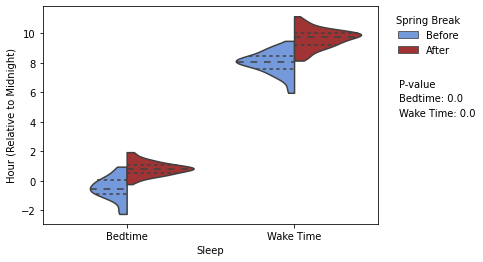

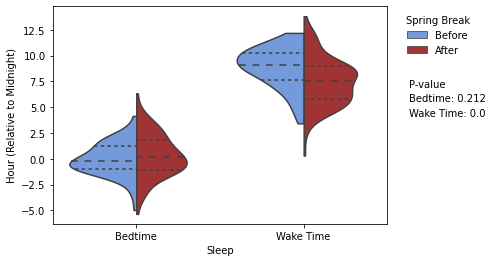

C1: 99	C2: xxvnhauv	cannot do a non-empty take from an empty axes.


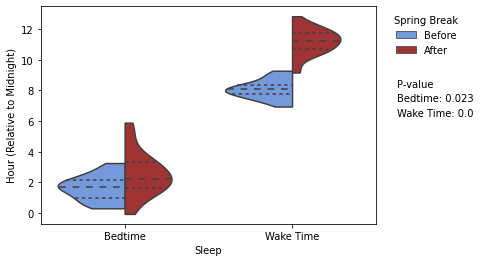

C1: 96	C2: 76w6lc1e	cannot do a non-empty take from an empty axes.


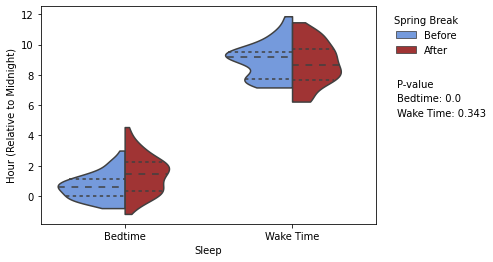

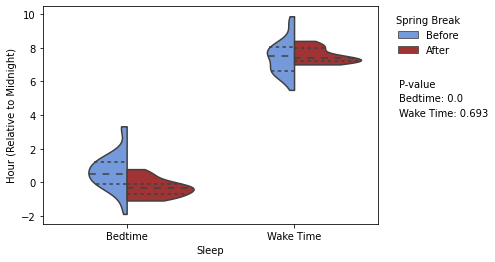

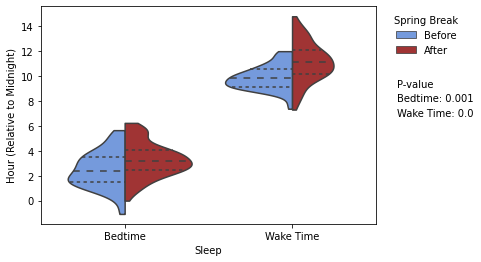

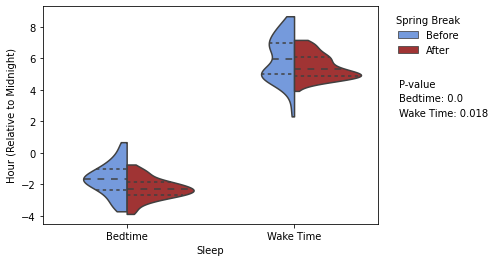

C1: 58	C2: pgvvwyvh	cannot do a non-empty take from an empty axes.
C1: 54	C2: 789gcb6u	cannot do a non-empty take from an empty axes.


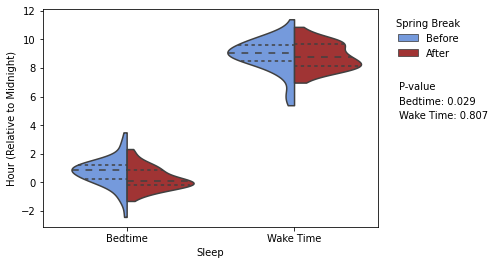

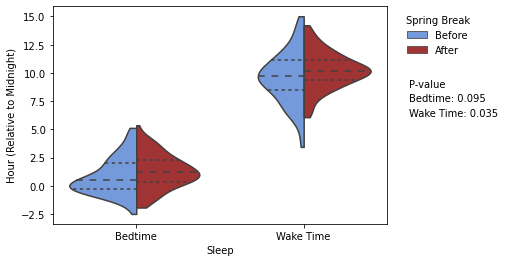

C1: 144	C2: 34483b37	cannot do a non-empty take from an empty axes.
C1: 217	C2: fxw5xupi	cannot do a non-empty take from an empty axes.


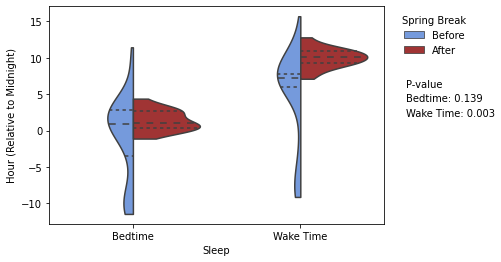

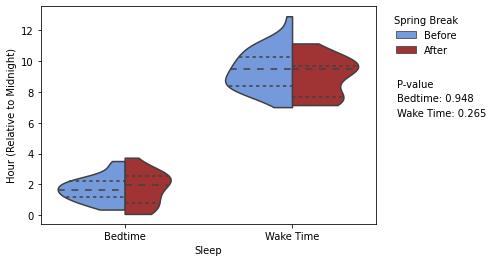

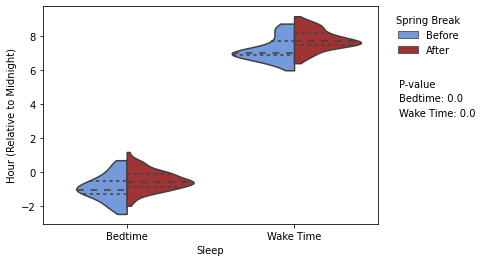

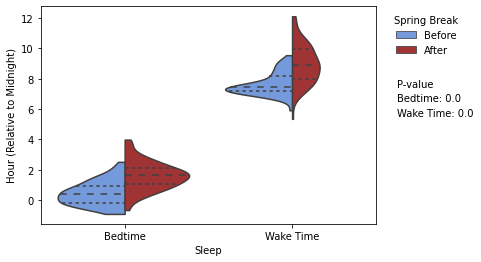

C1: 125	C2: mv14b8aj	cannot do a non-empty take from an empty axes.


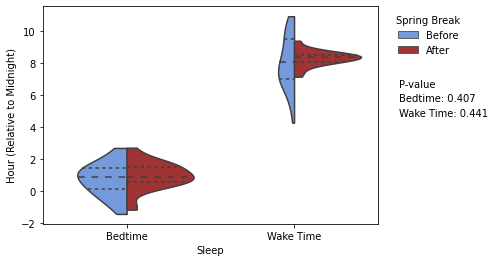

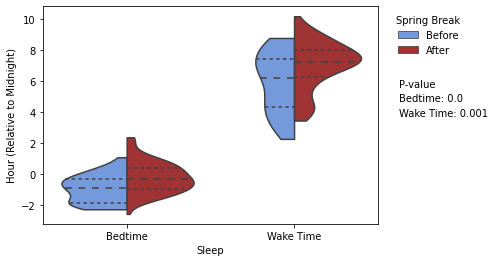

C1: 31	C2: uu6knbbx	cannot do a non-empty take from an empty axes.


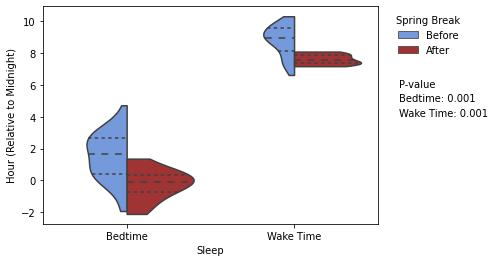

C1: 46	C2: ewvz3zm1	cannot do a non-empty take from an empty axes.


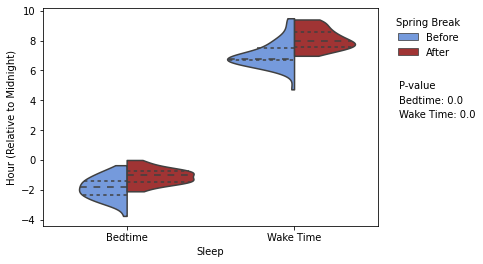

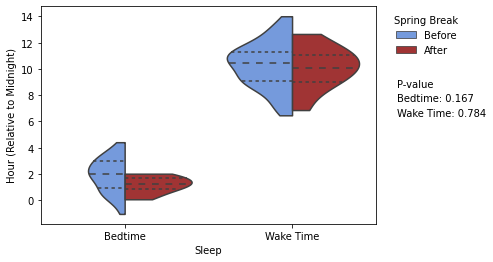

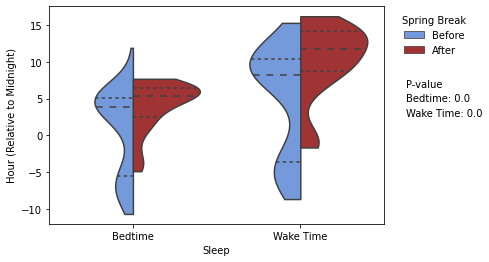

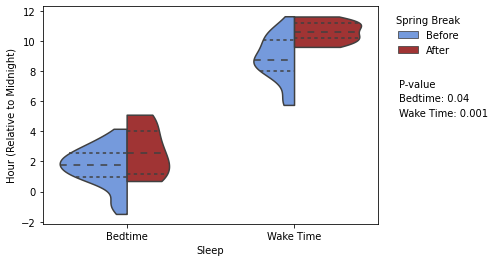

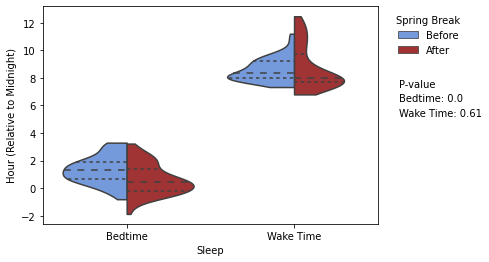

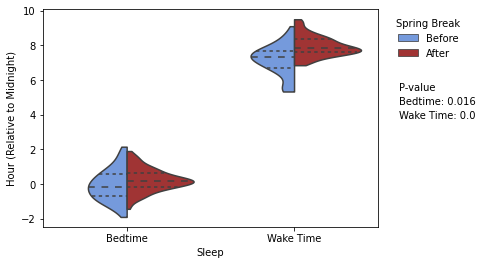

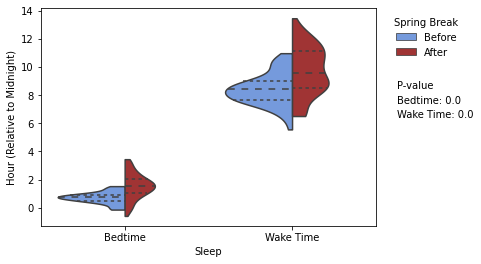

C1: 203	C2: q5y11ytm	cannot do a non-empty take from an empty axes.


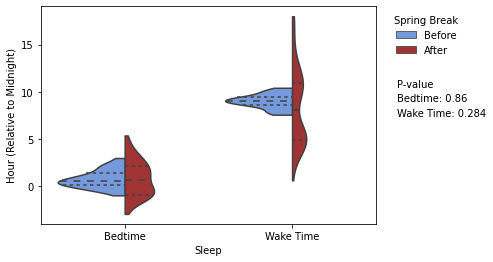

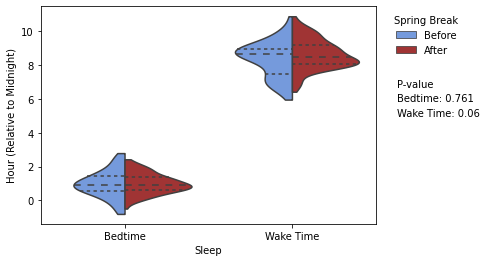

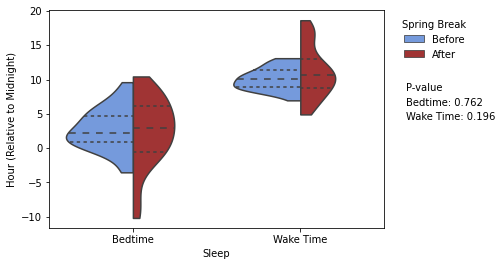

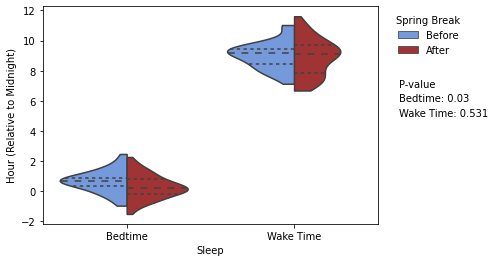

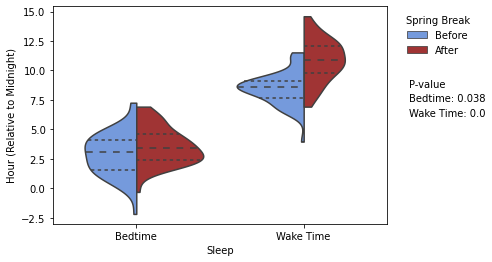

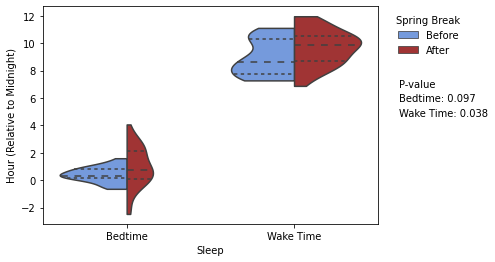

C1: 208	C2: rj4lxgvp	cannot do a non-empty take from an empty axes.
C1: 155	C2: r11k6uxz	cannot do a non-empty take from an empty axes.


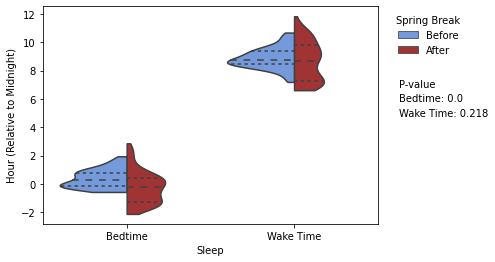

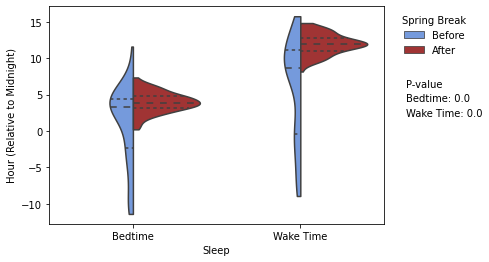

In [37]:
from scipy import stats
import math

for i in range(len(id_list)):
    # cohort 1
    c1_id = id_list['redcap1'][i]
    c1_pt = c1[c1['Id'] == c1_id]
    c1_pt_start_hour = c1_pt['StartTime'].dt.hour.values + c1_pt['StartTime'].dt.minute.values / 60
    c1_start = []
    for hour in c1_pt_start_hour:
        if hour < 12:
            c1_start.append(hour)
        else:
            c1_start.append(hour-24)
            
    # cohort 2
    c2_id = id_list['beiwe2'][i]
    c2_pt = c2[c2['beiwe'] == c2_id]
    c2_pt_start_hour = c2_pt['startTime'].dt.hour.values + c2_pt['startTime'].dt.minute.values / 60
    c2_start = []
    for hour in c2_pt_start_hour:
        if hour < 12:
            c2_start.append(hour)
        else:
            c2_start.append(hour-24)
            
    c1_end = c1_start + c1_pt["Duration"]/1000/60/60
    c2_end = c2_start + c2_pt["duration"]/1000/60/60
    
    try:
        c1_start = removeOutliers(c1_start)
        c1_end = removeOutliers(c1_end)
        c2_start = removeOutliers(c2_start)
        c2_end = removeOutliers(c2_end)

        if len(c1_start) > 5 and len(c2_start) > 5 and len(c1_end) > 5 and len(c2_end) > 5:
            df = pd.DataFrame(data={'Hour (Relative to Midnight)':c1_start,'Spring Break':['Before']*len(c1_start),'Sleep':['Bedtime']*len(c1_start)})
            df = df.append(pd.DataFrame(data={'Hour (Relative to Midnight)':c1_end,'Spring Break':['Before']*len(c1_end),'Sleep':['Wake Time']*len(c1_end)}))
            df = df.append(pd.DataFrame(data={'Hour (Relative to Midnight)':c2_start,'Spring Break':['After']*len(c2_start),'Sleep':['Bedtime']*len(c2_start)}))
            df = df.append(pd.DataFrame(data={'Hour (Relative to Midnight)':c2_end,'Spring Break':['After']*len(c2_end),'Sleep':['Wake Time']*len(c2_end)}))
            fig, ax = plt.subplots()
            sns.violinplot(x="Sleep",y="Hour (Relative to Midnight)",hue="Spring Break",data=df,palette=['cornflowerblue','firebrick'],split=True,inner='quartile',cut=0,ax=ax)

            ax.legend(loc='upper center',bbox_to_anchor=(1.15,1),frameon=False,ncol=1,title='Spring Break')
            #ax.set_ylim([-12,12])
            #ax.set_yticks(np.arange(-12,14,2))
            #ax.set_yticklabels(['12','14','16','18','20','22','0','2','4','6','8','10','12'])
            
            _,bedtime_p = stats.ttest_ind(c1_start, c2_start)
            _,waketime_p = stats.ttest_ind(c1_end, c2_end)
            ax.text(0.95,0.6,'P-Value"',ha='left',transform=fig.transFigure)
            ax.text(0.95,0.55,f'Bedtime: {round(bedtime_p,3)}',ha='left',transform=fig.transFigure)
            ax.text(0.95,0.5,f'Wake Time: {round(waketime_p,3)}',ha='left',transform=fig.transFigure)
            plt.show()
            plt.close()
    except Exception as inst:
        print(f'C1: {c1_id}\tC2: {c2_id}\t{inst}')